# 0. Imports

In [1]:
import sys
sys.path.append("../src/")

from utils import mean_std_cross_val_scores, mape

from extrucal.extrusion import throughput_cal

import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import shuffle
from tqdm import tqdm
from xgboost import XGBClassifier, XGBRegressor

import joblib

random.seed(0)

# 1. Dataset Read In and Modification

In [2]:
df = pd.read_csv("../data/dataset_generated_by_extrucal_from_1_rpm.csv")
df

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput
0,240,12.0,1400,1,144.0,14.4,2,37.513281
1,230,13.8,900,91,184.0,32.2,2,2438.274330
2,190,17.1,900,21,228.0,15.2,1,1041.914244
3,170,6.8,1200,1,170.0,34.0,2,10.273171
4,60,2.4,1200,41,72.0,3.6,1,37.045367
...,...,...,...,...,...,...,...,...
1505275,110,8.8,1300,11,110.0,22.0,1,99.018883
1505276,110,4.4,1200,61,132.0,17.6,2,247.563530
1505277,100,4.0,1000,61,60.0,14.0,2,57.198810
1505278,120,8.4,1000,91,216.0,21.6,2,1002.149759


In [3]:
df = df.query("throughput != 0")

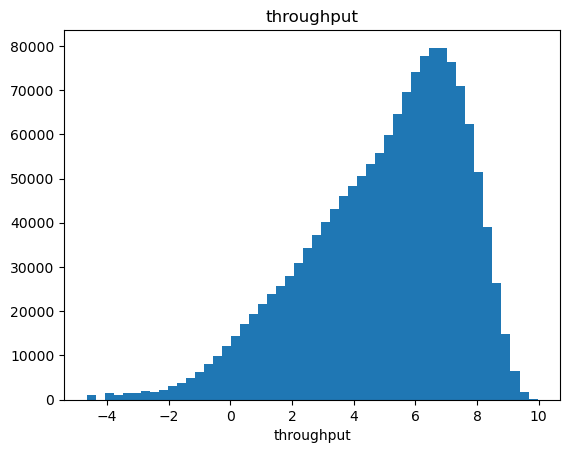

In [4]:
# Checking the distribution of throughput after log transformation
plt.figure()
plt.hist(np.log(df["throughput"]), bins=50)
plt.title("throughput")
plt.xlabel("throughput")
plt.show();

In [5]:
# Apply log-transformation to target
df["log_throughput"] = np.log(df["throughput"])

C:\Users\johnw\AppData\Local\Temp\ipykernel_15616\4271783934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_throughput"] = np.log(df["throughput"])


# 2. Train/Test Split

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput,log_throughput
402586,100,4.0,1400,41,120.0,6.0,2,193.551484,5.265544
451140,160,8.0,1000,81,192.0,32.0,1,1277.425613,7.152602
870846,190,3.8,1400,51,114.0,19.0,2,342.272722,5.835608
158674,190,7.6,1100,61,266.0,11.4,2,1767.841785,7.477515
1188355,250,17.5,900,51,150.0,20.0,1,2197.494687,7.695073


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204173 entries, 402586 to 773667
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   extruder_size    1204173 non-null  int64  
 1   metering_depth   1204173 non-null  float64
 2   polymer_density  1204173 non-null  int64  
 3   rpm              1204173 non-null  int64  
 4   screw_pitch      1204173 non-null  float64
 5   flight_width     1204173 non-null  float64
 6   number_flight    1204173 non-null  int64  
 7   throughput       1204173 non-null  float64
 8   log_throughput   1204173 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 91.9 MB


In [8]:
X_train = train_df.drop(columns=["throughput", "log_throughput"])
y_train = train_df["log_throughput"]

X_test = test_df.drop(columns=["throughput", "log_throughput"])
y_test = test_df["log_throughput"]

# 3. Preparation of Preprocessors

In [9]:
no_log_features = ["extruder_size", "polymer_density", "rpm", "number_flight"]
log_features = ["metering_depth", "screw_pitch", "flight_width"]

In [10]:
no_log_transformer = make_pipeline(
    StandardScaler(),
)

In [11]:
log_transformer = make_pipeline(
    FunctionTransformer(np.log),
    StandardScaler(),
)

In [12]:
preprocessor = make_column_transformer(
    (no_log_transformer, no_log_features),
    (log_transformer, log_features)
)

# 4. Cross-Validation of ML Models

In [13]:
results = {}

In [14]:
mape_scorer = make_scorer(mape, greater_is_better=False)

## 4.1. Baseline Model

In [15]:
pipe_dummy = make_pipeline(preprocessor, DummyRegressor())

In [16]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
)

In [17]:
pd.DataFrame(results)

,Dummy
fit_time,0.222 (+/- 0.016)
score_time,0.029 (+/- 0.005)
test_score,-6.259 (+/- 0.023)
train_score,-6.259 (+/- 0.006)


## 4.2. ML Models

In [18]:
random_state = 123

pipe_ridge = make_pipeline(
    preprocessor, Ridge(max_iter=2000, random_state=random_state)
)
pipe_lasso = make_pipeline(
    preprocessor, Lasso(max_iter=2000, random_state=random_state)
)
pipe_rf = make_pipeline(
    preprocessor, RandomForestRegressor(random_state=random_state)
)
pipe_xgb = make_pipeline(
    preprocessor, XGBRegressor(random_state=random_state, verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=random_state))
pipe_catb = make_pipeline(
    preprocessor,
    CatBoostRegressor(random_state=random_state, verbose=0, loss_function="RMSE"),
)

In [19]:
models = {
    "ridge": pipe_ridge,
    "lass": pipe_lasso,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [20]:
%%time

for name, model in tqdm(models.items()):
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
    )

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [36:02<00:00, 360.38s/it]

CPU times: total: 1h 37min 48s
Wall time: 36min 2s


In [21]:
pd.DataFrame(results)

,Dummy,ridge,lass,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.222 (+/- 0.016),0.292 (+/- 0.013),0.550 (+/- 0.053),281.235 (+/- 4.487),23.086 (+/- 0.420),3.063 (+/- 0.019),62.410 (+/- 2.397)
score_time,0.029 (+/- 0.005),0.035 (+/- 0.006),0.039 (+/- 0.005),12.141 (+/- 1.605),0.167 (+/- 0.024),0.336 (+/- 0.017),0.098 (+/- 0.013)
test_score,-6.259 (+/- 0.023),-0.509 (+/- 0.002),-2.739 (+/- 0.013),-0.003 (+/- 0.000),-0.005 (+/- 0.000),-0.008 (+/- 0.000),-0.001 (+/- 0.000)
train_score,-6.259 (+/- 0.006),-0.509 (+/- 0.000),-2.739 (+/- 0.001),-0.000 (+/- 0.000),-0.005 (+/- 0.000),-0.007 (+/- 0.000),-0.001 (+/- 0.000)


#### `CatBoost` still perform best

# 5. Evaluation of `CatBoost` Model

In [22]:
%%time

pipe_catb.fit(X_train, y_train)

CPU times: total: 11min 25s
Wall time: 1min 17s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['extruder_size',
                                                   'polymer_density', 'rpm',
                                                   'number_flight']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['metering_depth',
     

## 5.1. Comparison between Prediction and `y_test`

In [23]:
y_pred = np.exp(pipe_catb.predict(X_test))

In [24]:
y_test = np.exp(y_test)

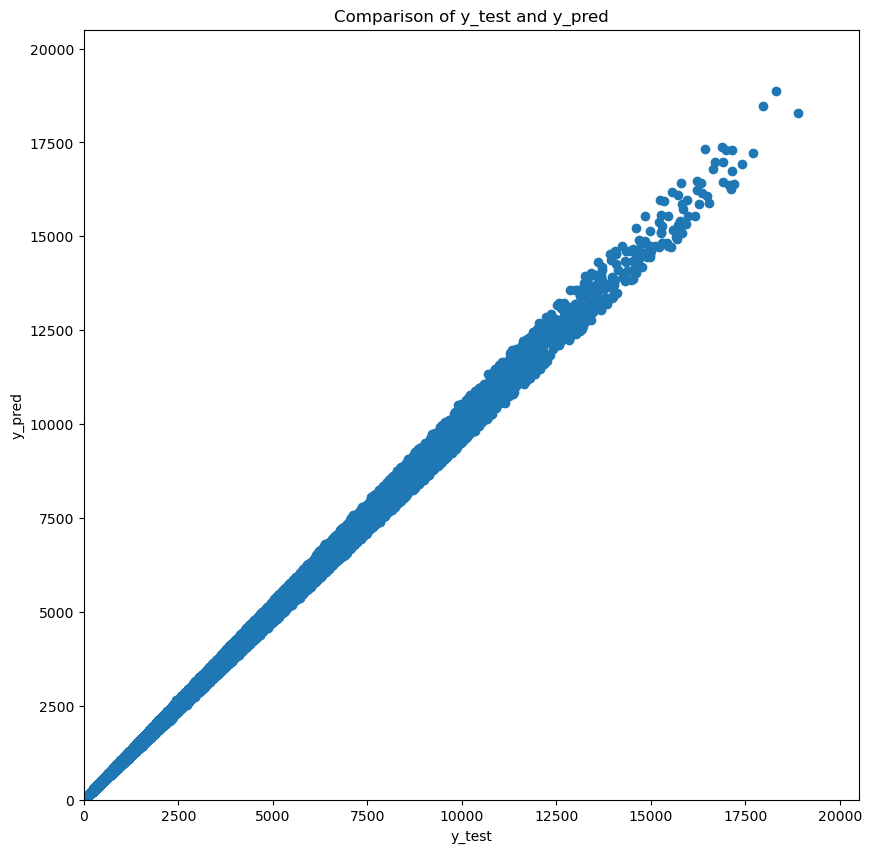

In [25]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.xlim(0, 20500)
plt.ylim(0, 20500)
plt.title("Comparison of y_test and y_pred")
plt.show();

In [26]:
mape(y_test, y_pred)

2.5360990078674446

## 5.2. Comparison with `extrucal` results

In [27]:
extruder_size = []
for i in range(25, 251, 25):
    extruder_size.extend([i]*5)

metering_depth_percent = [0.05] * 50
polymer_density = [1000] * 50
screw_pitch_percent = [1] * 50
flight_width_percent = [0.1] * 50
number_flight = [1] * 50
rpm = [r for r in range(1, 42, 10)] * 10  # the results are not zero for 0 rpm because of the log related stuffs.

In [28]:
df = pd.DataFrame(
    {"extruder_size": extruder_size,
     "metering_depth_percent": metering_depth_percent,
     "polymer_density": polymer_density,
     "screw_pitch_percent": screw_pitch_percent,
     "flight_width_percent": flight_width_percent,
     "number_flight": number_flight,
     "rpm": rpm}
)

df["metering_depth"] = df["extruder_size"] * df["metering_depth_percent"]
df["screw_pitch"] = df["extruder_size"] * df["screw_pitch_percent"]
df["flight_width"] = df["extruder_size"] * df["flight_width_percent"]

new_col_order = [
    "extruder_size", "metering_depth", "polymer_density", 
    "rpm", "screw_pitch", "flight_width", "number_flight", ]

df = df[new_col_order]
df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight
0,25,1.25,1000,1,25,2.5,1
1,25,1.25,1000,11,25,2.5,1
2,25,1.25,1000,21,25,2.5,1
3,25,1.25,1000,31,25,2.5,1
4,25,1.25,1000,41,25,2.5,1


In [29]:
df["CatBoost_model"] = np.exp(pipe_catb.predict(df))

In [30]:
df["extrucal"] = df.apply(
    lambda row: throughput_cal(
        row["extruder_size"],
        row["metering_depth"],
        row["polymer_density"],
        row["rpm"],
        row["screw_pitch"],
        row["flight_width"],
        int(row["number_flight"])), axis=1
)

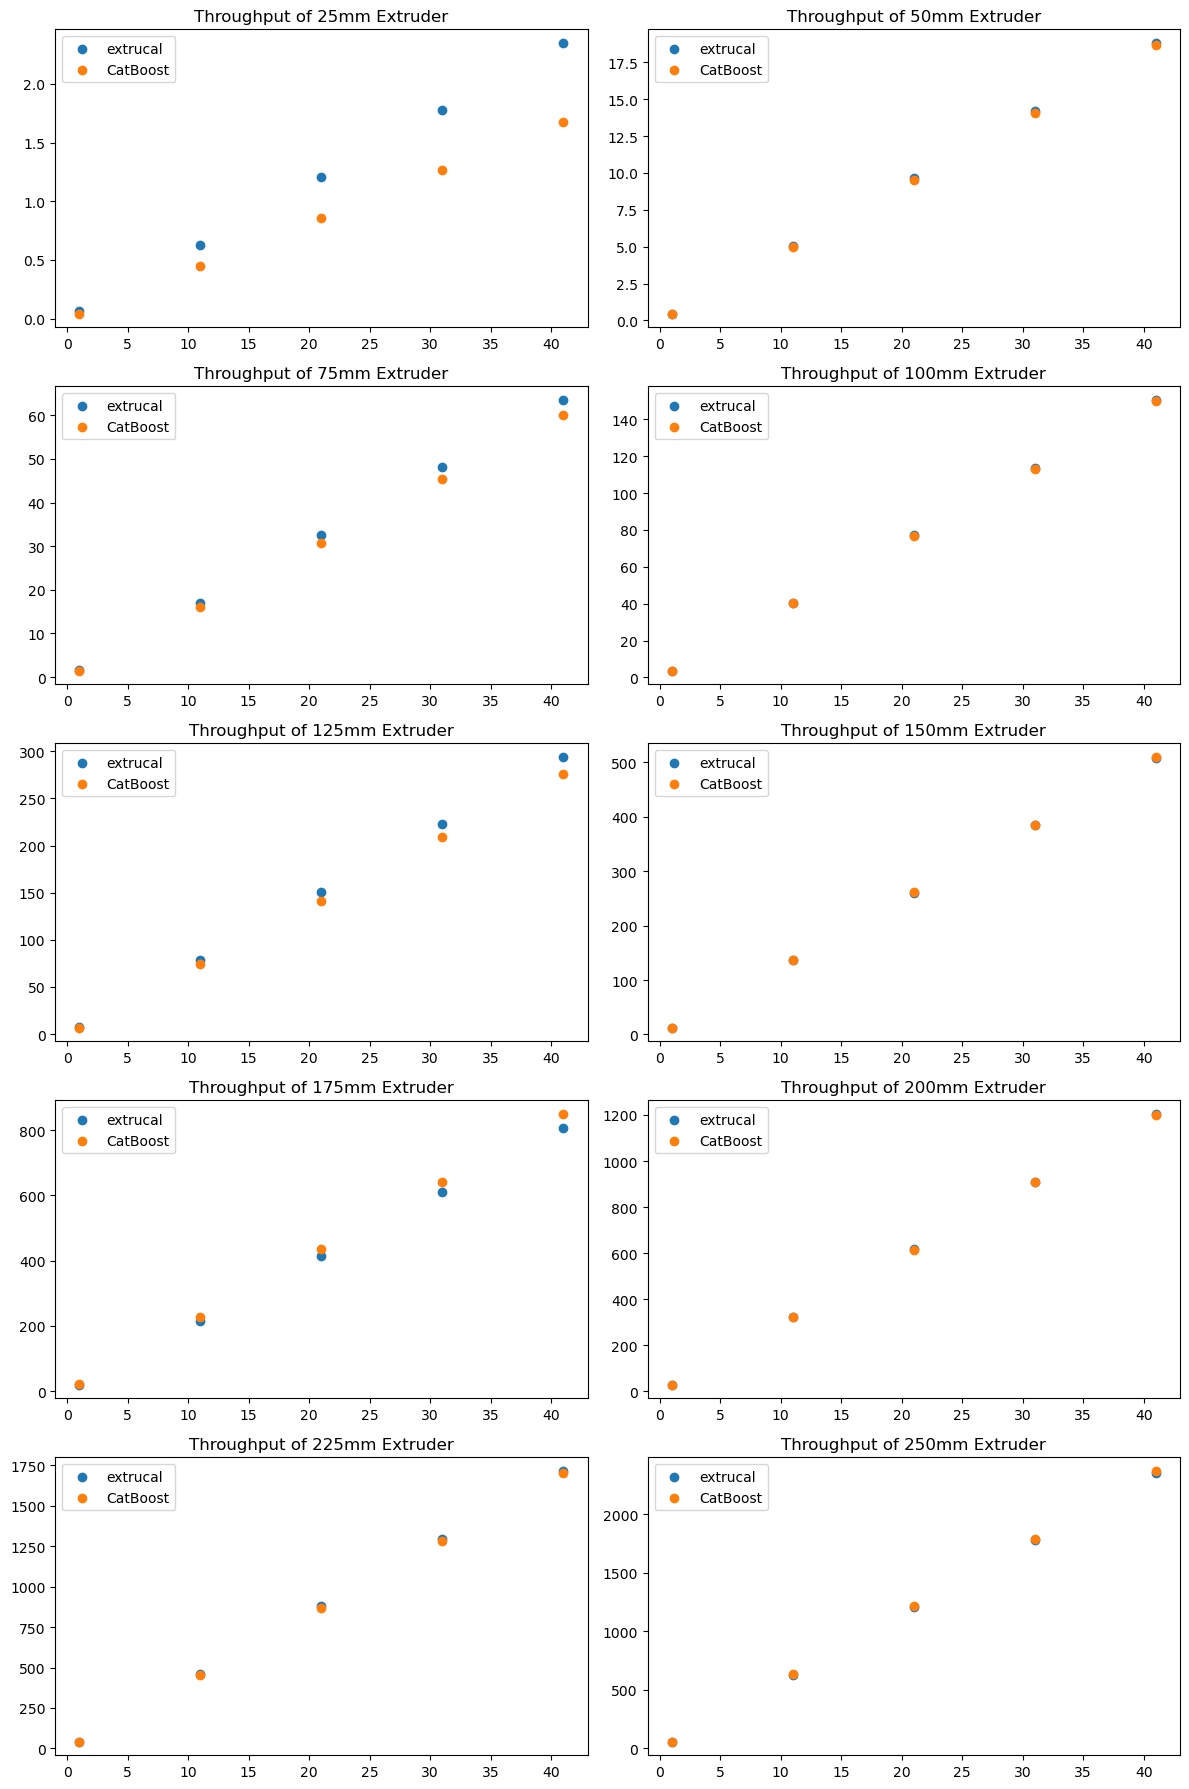

In [31]:
fig, axs = plt.subplots(figsize=(12, 18), nrows=5, ncols=2)
r = 0
c = 0
for size in list(df["extruder_size"].unique()):
    temp = df.query(f"extruder_size == {size}")
    axs[r, c].scatter(temp["rpm"], temp["extrucal"], label="extrucal")
    axs[r, c].scatter(temp["rpm"], temp["CatBoost_model"], label="CatBoost")
    axs[r, c].set_title(f"Throughput of {size}mm Extruder")
    axs[r, c].legend()
    if c < 1:
        c += 1
    else:
        r += 1
        c = 0
plt.tight_layout()
plt.show();

#### The throughput prediction for very low screw RPM (i.e. 1) shows a bit off values"

In [32]:
joblib.dump(pipe_catb, "../models/from_one_catb_model.pkl")

['../models/from_one_catb_model.pkl']